# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal is to build a predictive model that can quantify the relationship between various features of used cars (such as make, model, year, mileage, and other attributes) and their corresponding market prices. This involves identifying the key predictors that significantly influence car prices, understanding their impact, and developing a data-driven model to forecast the price of a used car based on these factors. The outcome will guide the used car dealership in pricing strategies and inventory acquisition decisions to align with consumer preferences.

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [47]:
warnings.filterwarnings('ignore')

In [48]:
# Load the dataset and display the first few rows to get an initial impression of its structure and content.
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [49]:
# Check the data types of each column to understand how the data is stored.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [50]:
df.shape

(426880, 18)

In [51]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [53]:
# Identify the columns in the dataset
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [54]:
# Check for missing values in the dataset
missing = df.isnull().sum()
missing_percentage = (missing / len(df)) * 100

In [55]:
missing_summary = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

missing_summary

,Missing Values,Percentage
size,306361,71.767476
cylinders,177678,41.622470
condition,174104,40.785232
VIN,161042,37.725356
drive,130567,30.586347
paint_color,130203,30.501078
type,92858,21.752717
manufacturer,17646,4.133714
title_status,8242,1.930753
model,5277,1.236179


In [56]:
# Check for unique values in each column  
df.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [57]:
# Check number of records where the value is equal to 0
df.eq(0).sum()

id                  0
region              0
price           32895
year                0
manufacturer        0
model               0
condition           0
cylinders           0
fuel                0
odometer         1965
title_status        0
transmission        0
VIN                 0
drive               0
size                0
type                0
paint_color         0
state               0
dtype: int64

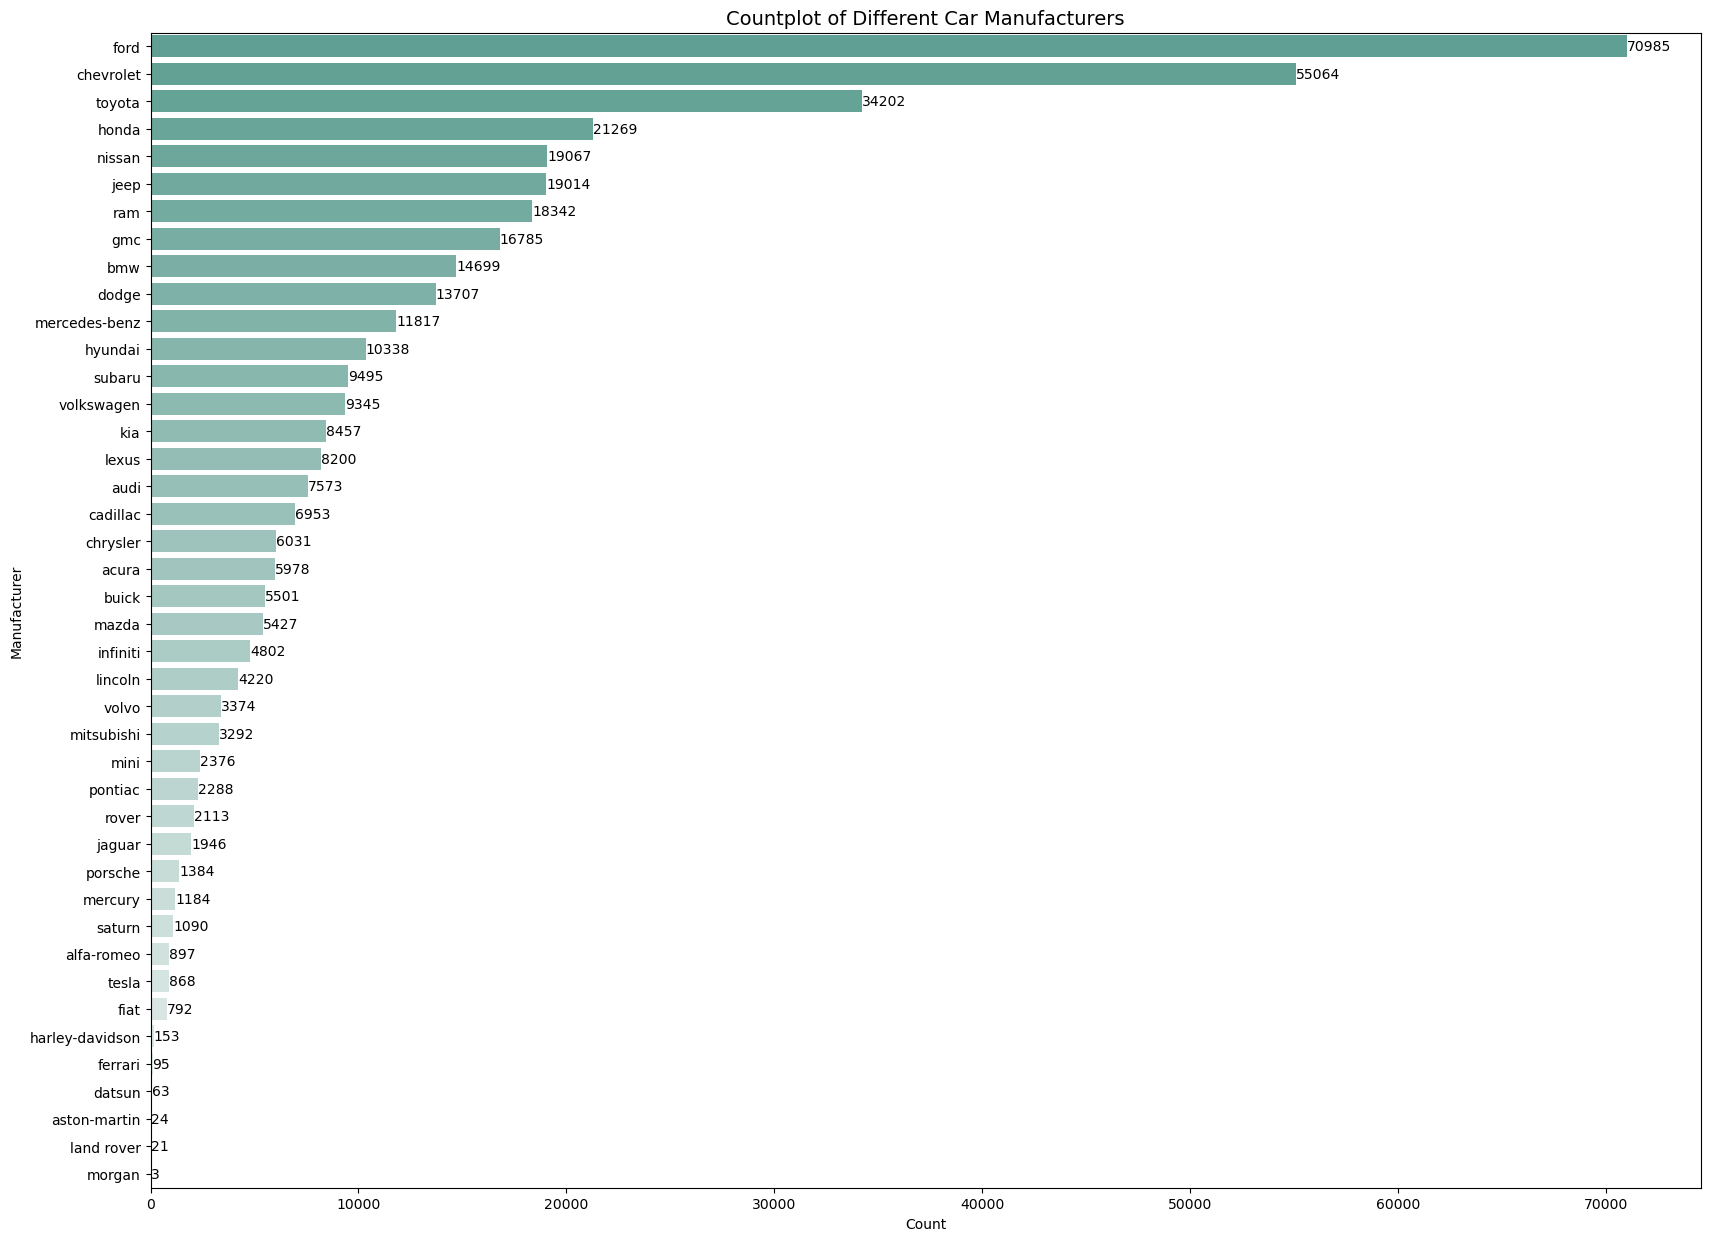

In [58]:
# Countplot of different car manufacturer
plt.figure(figsize = (20, 15))
manufacturer_counts = df['manufacturer'].value_counts()
colors = sns.color_palette("light:#5A9_r", len(manufacturer_counts))
ax = sns.countplot(y='manufacturer', data=df, order=manufacturer_counts.index, palette=colors)
for p in ax.patches:
    plt.text(p.get_width() + 1, p.get_y() + p.get_height() / 2, int(p.get_width()), ha="left", va="center")
plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.title('Countplot of Different Car Manufacturers', fontsize = 14)
plt.show()

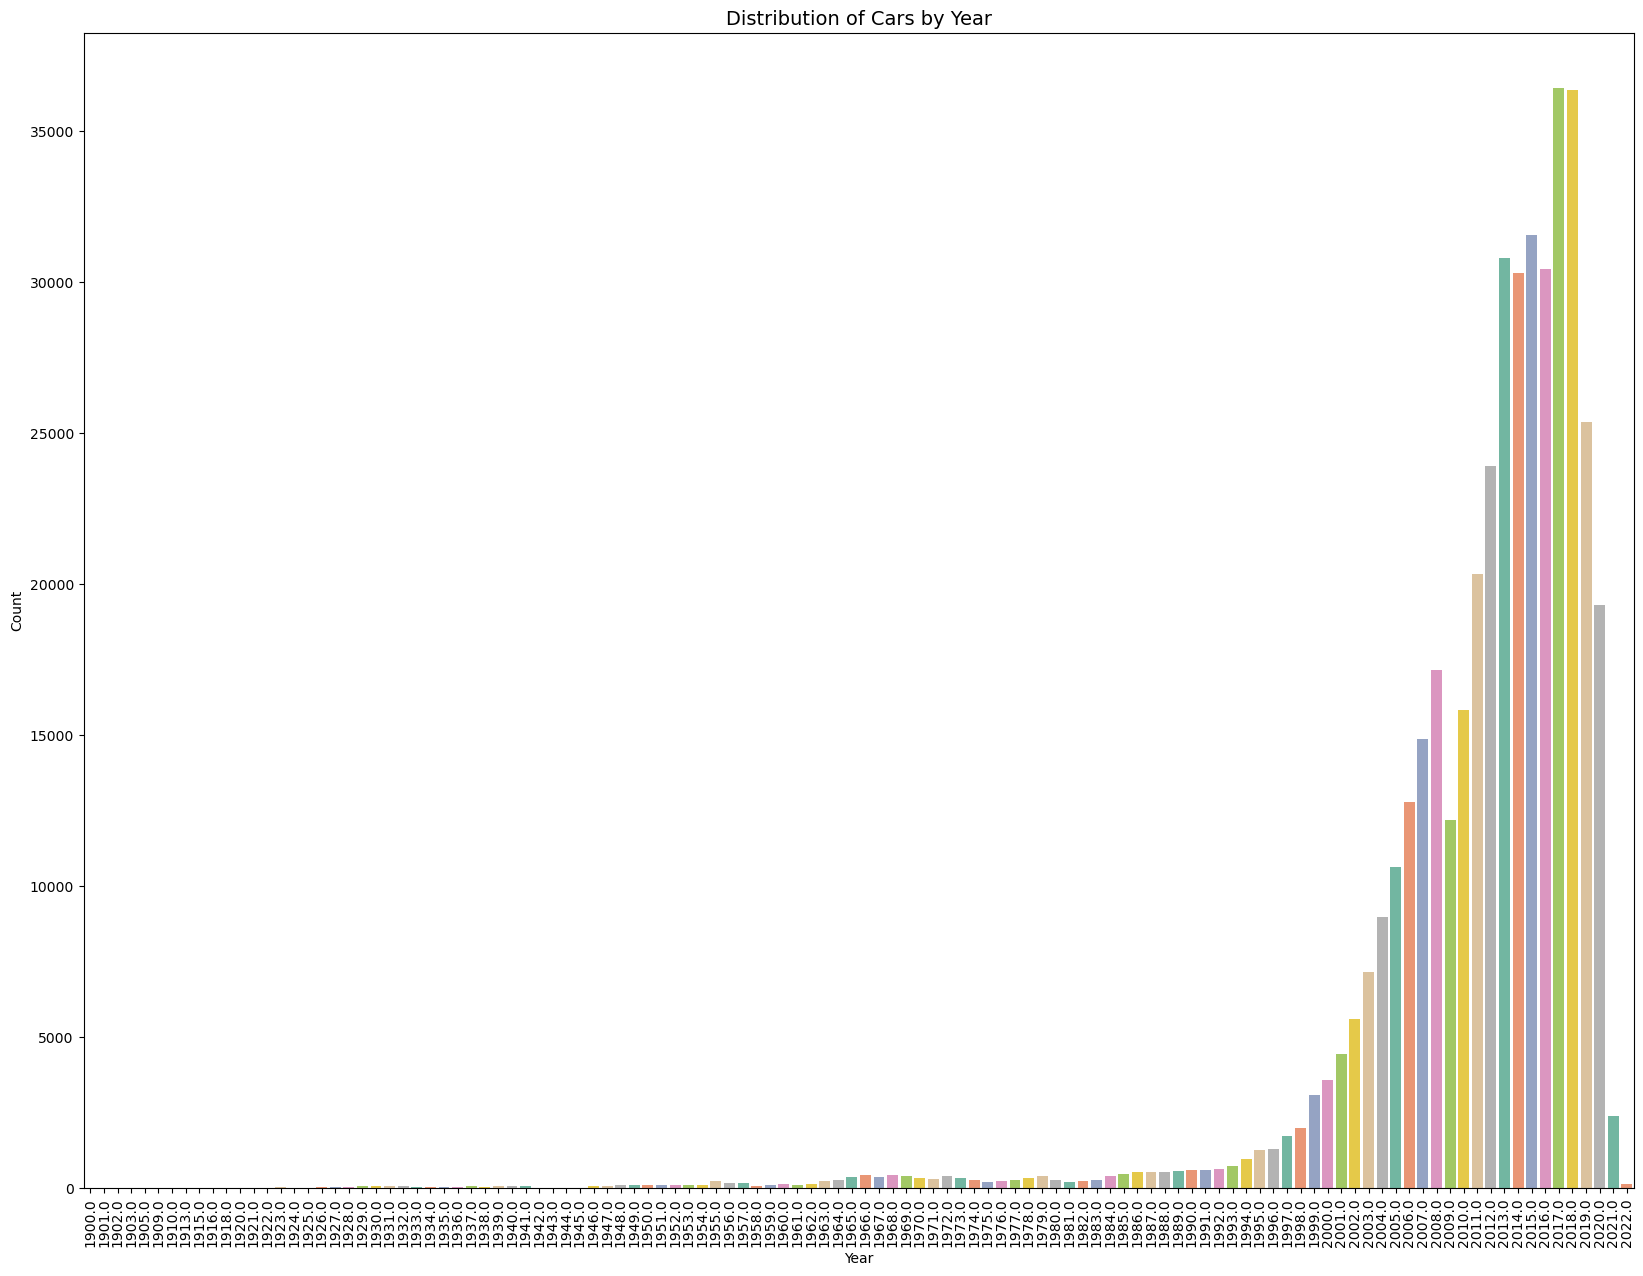

In [59]:
# Countplot of cars by year
plt.figure(figsize=(20, 15))
colors = sns.color_palette("Set2", len(df['year'].dropna().unique()))
ax = sns.countplot(x='year', data=df, order=sorted(df['year'].dropna().unique()), palette=colors)
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Cars by Year', fontsize = 14)
plt.show()

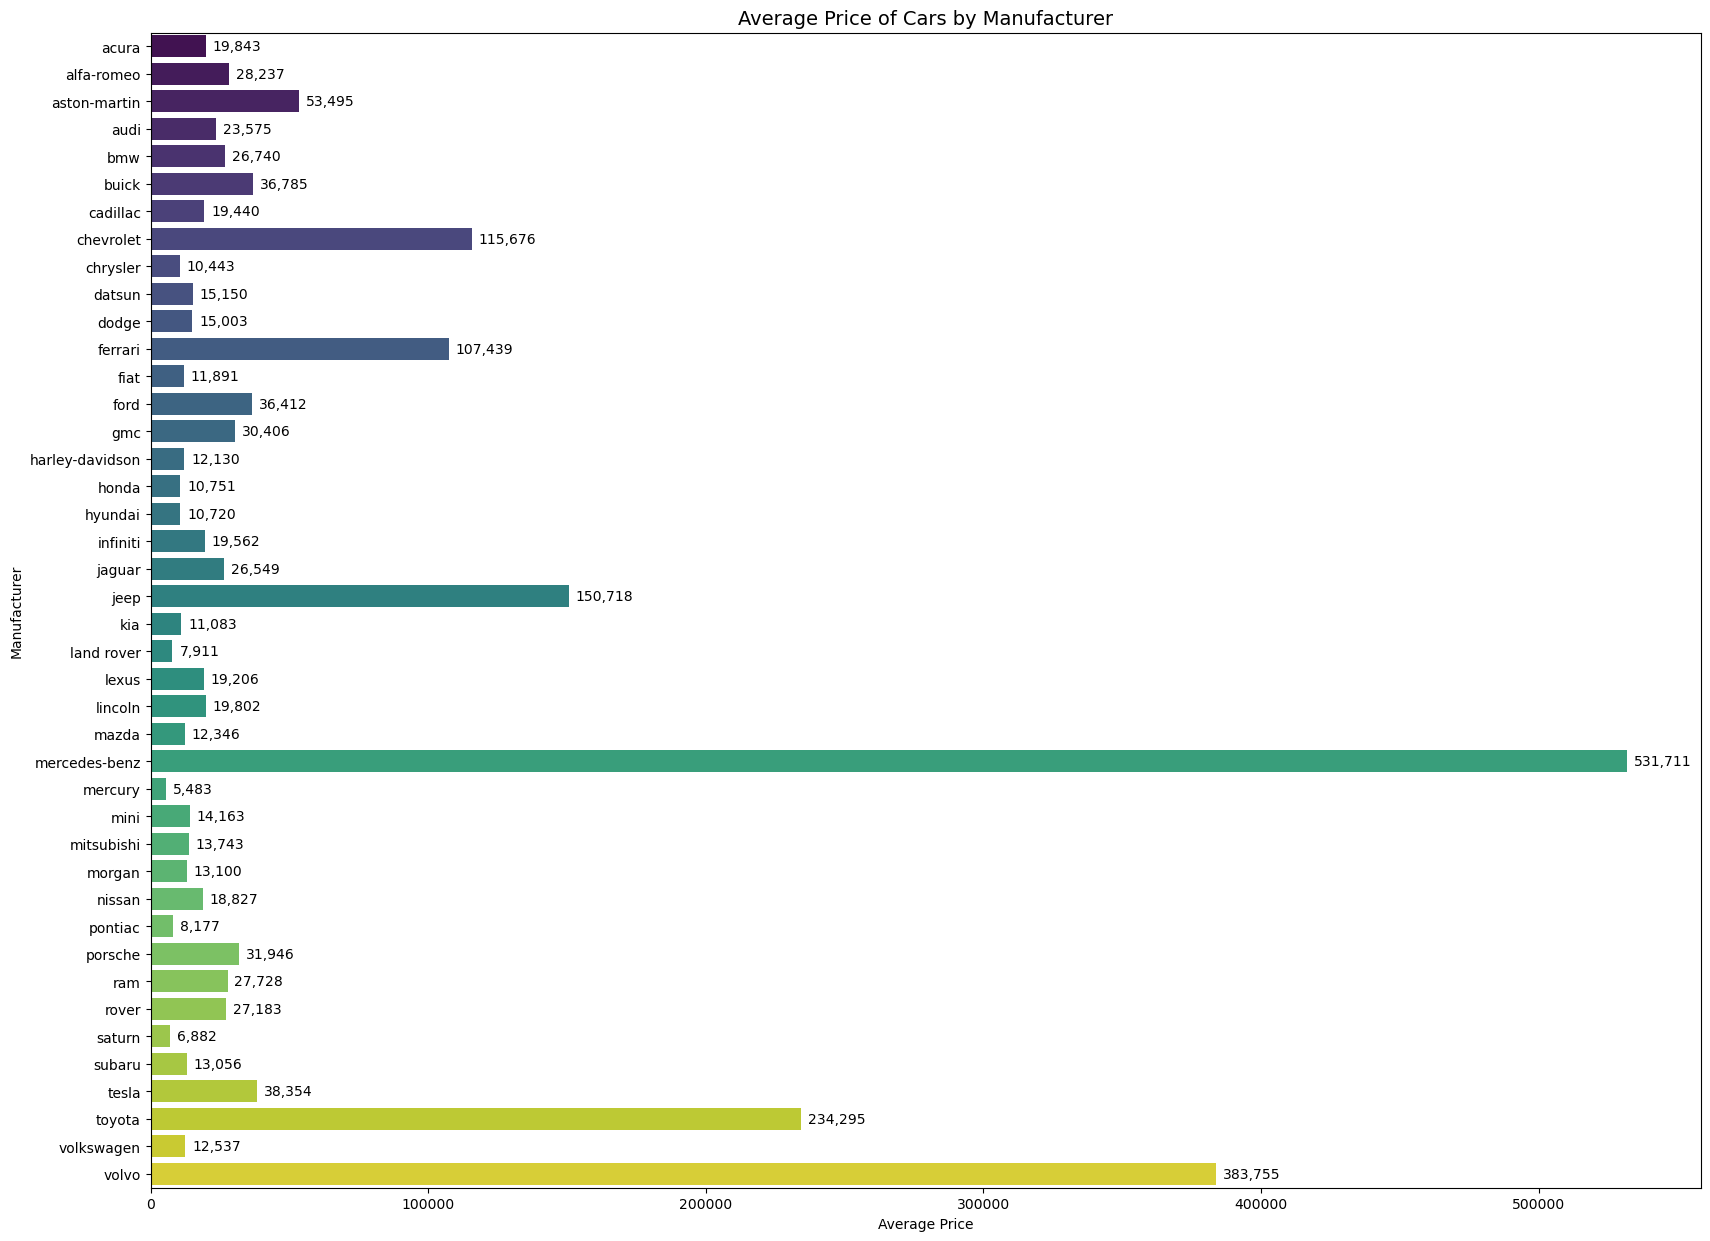

In [60]:
# Average price of the car by manufacturer
average_price_by_manufacturer = df.groupby('manufacturer')['price'].mean().reset_index()
plt.figure(figsize = (20, 15))
ax = sns.barplot(x='price', y='manufacturer', data=average_price_by_manufacturer, palette='viridis')
# Add data labels
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:,.0f}', (width, p.get_y() + p.get_height() / 2.),ha='left', va='center',xytext=(5, 0), textcoords='offset points')
plt.xlabel('Average Price')
plt.ylabel('Manufacturer')
plt.title("Average Price of Cars by Manufacturer", fontsize = 14)
plt.show()

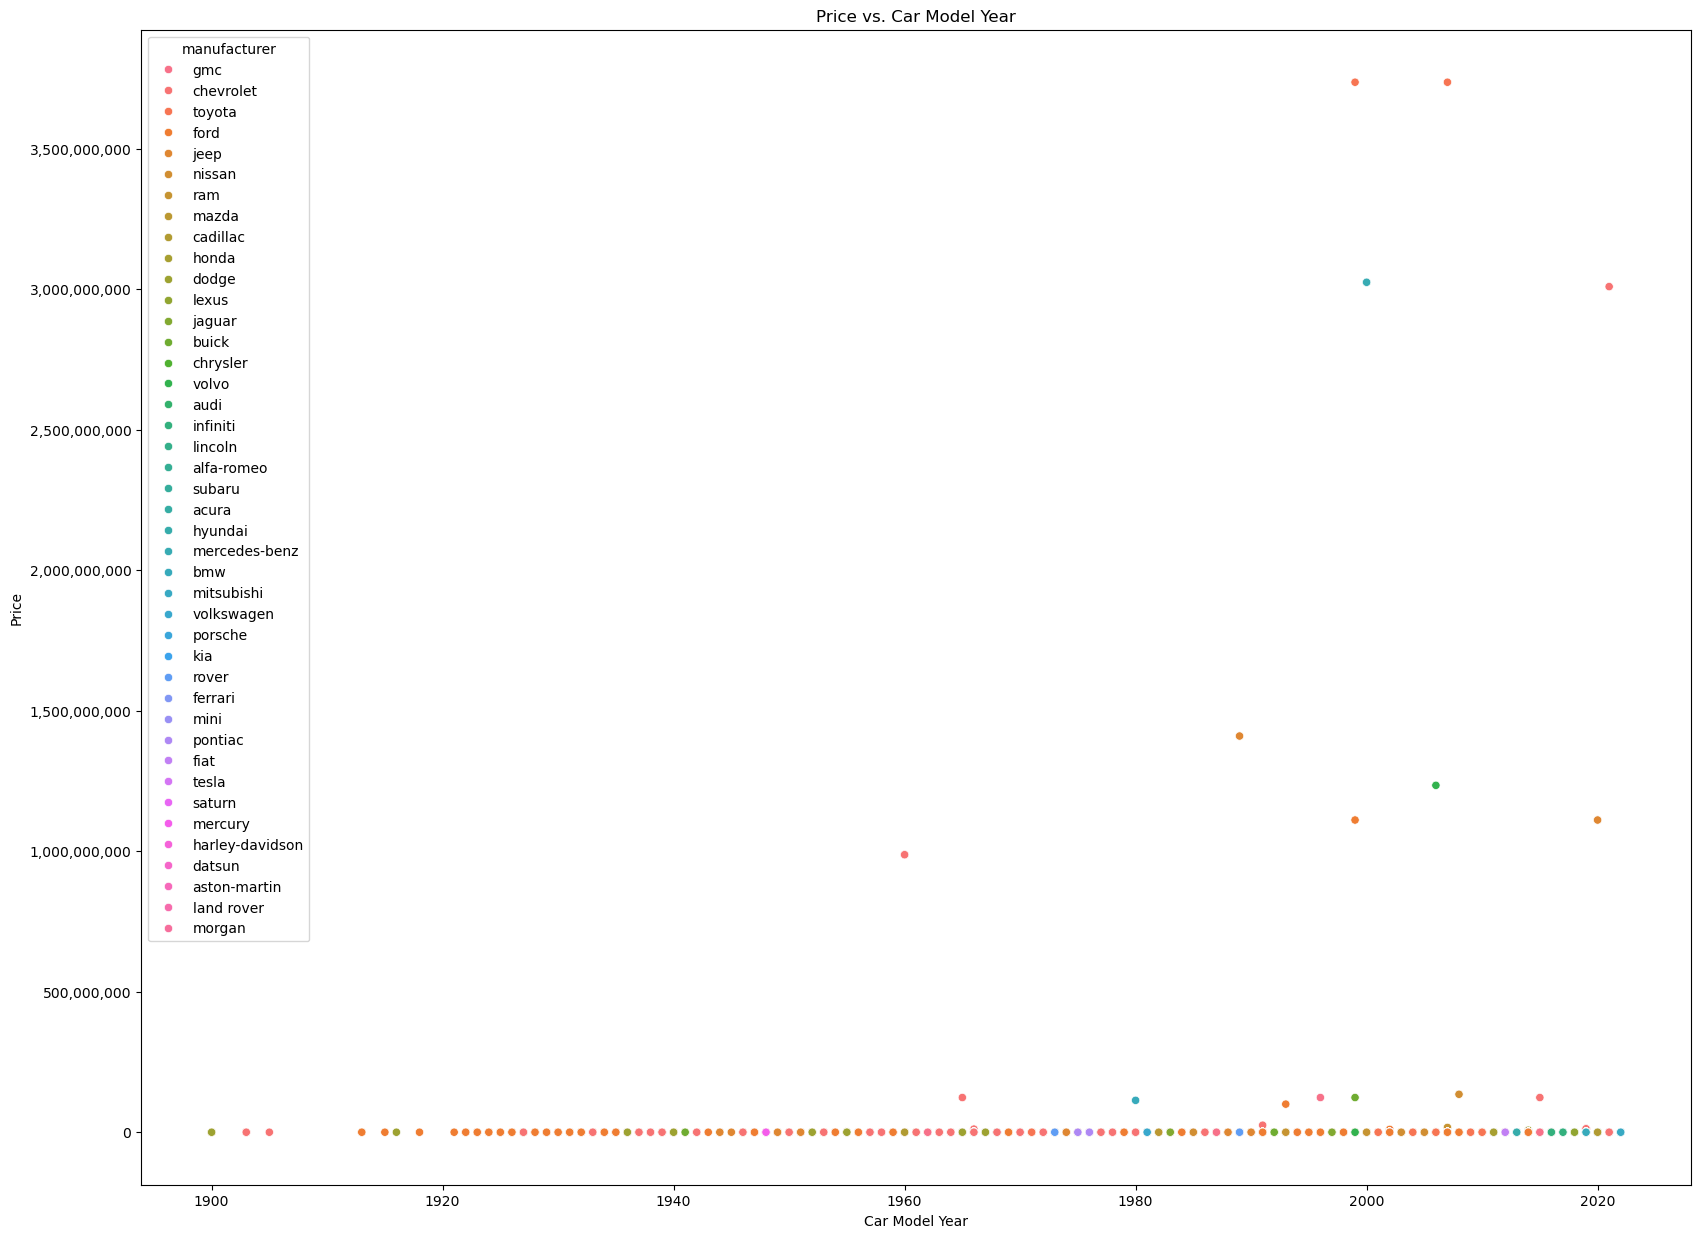

In [61]:
# Price vs. Car Model Year
from matplotlib.ticker import FuncFormatter, MaxNLocator
def currency_format(x, pos):
    return f'{x:,.0f}'
plt.figure(figsize=(20, 15))
ax = sns.scatterplot(x='year', y='price', data=df, hue='manufacturer', palette='husl')
ax.yaxis.set_major_formatter(FuncFormatter(currency_format))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Car Model Year')
plt.ylabel('Price')
plt.title('Price vs. Car Model Year')
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [63]:
# Converting the datatype to best possilble datatypes
df_1 = df.convert_dtypes()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            426880 non-null  Int64 
 1   region        426880 non-null  string
 2   price         426880 non-null  Int64 
 3   year          425675 non-null  Int64 
 4   manufacturer  409234 non-null  string
 5   model         421603 non-null  string
 6   condition     252776 non-null  string
 7   cylinders     249202 non-null  string
 8   fuel          423867 non-null  string
 9   odometer      422480 non-null  Int64 
 10  title_status  418638 non-null  string
 11  transmission  424324 non-null  string
 12  VIN           265838 non-null  string
 13  drive         296313 non-null  string
 14  size          120519 non-null  string
 15  type          334022 non-null  string
 16  paint_color   296677 non-null  string
 17  state         426880 non-null  string
dtypes: Int64(4), string(14)


In [64]:
# Drop Columns with large unique entries.
df_2 = df_1.drop(columns = ['id', 'VIN','model','size','state','region'])
df_2.describe(include = ['string'])

,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color
count,409234,252776,249202,423867,418638,424324,296313,334022,296677
unique,42,6,8,5,6,3,3,13,12
top,ford,good,6 cylinders,gas,clean,automatic,4wd,sedan,white
freq,70985,121456,94169,356209,405117,336524,131904,87056,79285


In [65]:
df_2.groupby('title_status').size()

title_status
clean         405117
lien            1422
missing          814
parts only       198
rebuilt         7219
salvage         3868
dtype: int64

In [66]:
# Dropping rows where the title_status is not clean
df_3 = df_2.drop(df[df.title_status == 'salvage'].index)
df_3 = df_3.drop(df[df.title_status == 'parts only'].index)
df_3 = df_3.drop(df[df.title_status == 'missing'].index)
df_3 = df_3.drop(df[df.title_status == 'lien'].index)
df_3 = df_3.drop(df[df.title_status == 'rebuilt'].index)

In [67]:
df_3.groupby('title_status').size()

title_status
clean    405117
dtype: int64

In [68]:
df_3.groupby('manufacturer').size()

manufacturer
acura               5837
alfa-romeo           893
aston-martin          24
audi                7454
bmw                14424
buick               5292
cadillac            6736
chevrolet          53256
chrysler            5831
datsun                60
dodge              13188
ferrari               89
fiat                 772
ford               69050
gmc                16428
harley-davidson      150
honda              20127
hyundai            10021
infiniti            4648
jaguar              1920
jeep               18459
kia                 8238
land rover            21
lexus               8067
lincoln             4117
mazda               5252
mercedes-benz      11596
mercury             1152
mini                2343
mitsubishi          3219
morgan                 3
nissan             17998
pontiac             2191
porsche             1357
ram                17888
rover               2063
saturn              1061
subaru              8879
tesla                852
toyota      

In [69]:
df_3.isnull().sum()

price                0
year              1095
manufacturer     16920
condition       170204
cylinders       174368
fuel              2986
odometer          4393
title_status      8242
transmission      2550
drive           126724
type             88707
paint_color     126431
dtype: int64

In [70]:
df_imp = df_3.copy()

In [71]:
# Drop the rows with missing values
# Using Simple Imputer for completing missing values with simple strategies.
imp_features = ['manufacturer','condition','cylinders','drive','type','paint_color']
imp_frequent = SimpleImputer(missing_values=pd.NA, strategy='most_frequent')
for i in imp_features:
    imp_frequent.fit(df_imp[[i]])
    imp_freq_trans = imp_frequent.transform(df_imp[[i]])
    df_imp[i] = pd.DataFrame(imp_freq_trans)

In [72]:
df_imp.isnull().sum()

price               0
year             1095
manufacturer    13059
condition       13059
cylinders       13059
fuel             2986
odometer         4393
title_status     8242
transmission     2550
drive           13059
type            13059
paint_color     13059
dtype: int64

In [73]:
# Now drop the rows with missing values 
df_vehicle = df_imp.dropna()

In [74]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384639 entries, 27 to 413358
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         384639 non-null  Int64 
 1   year          384639 non-null  Int64 
 2   manufacturer  384639 non-null  object
 3   condition     384639 non-null  object
 4   cylinders     384639 non-null  object
 5   fuel          384639 non-null  string
 6   odometer      384639 non-null  Int64 
 7   title_status  384639 non-null  string
 8   transmission  384639 non-null  string
 9   drive         384639 non-null  object
 10  type          384639 non-null  object
 11  paint_color   384639 non-null  object
dtypes: Int64(3), object(6), string(3)
memory usage: 39.2+ MB


#### Perform OneHotEncoding

In [76]:
df_vehicles = df_vehicle.drop(columns = ['manufacturer', 'title_status'])

In [77]:
# Remove the features as it has 42 unique value
features = ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color' ]

In [78]:
df_enc = pd.get_dummies(df_vehicles[features])

In [79]:
df_enc1 = df_vehicles.drop(columns = features, axis=1)
df_encoder = df_enc1.join(df_enc)

In [80]:
df_encoder.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384639 entries, 27 to 413358
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   384639 non-null  Int64  
 1   year                    384639 non-null  Int64  
 2   odometer                384639 non-null  Int64  
 3   condition_excellent     384639 non-null  bool   
 4   condition_fair          384639 non-null  bool   
 5   condition_good          384639 non-null  bool   
 6   condition_like new      384639 non-null  bool   
 7   condition_new           384639 non-null  bool   
 8   condition_salvage       384639 non-null  bool   
 9   cylinders_10 cylinders  384639 non-null  bool   
 10  cylinders_12 cylinders  384639 non-null  bool   
 11  cylinders_3 cylinders   384639 non-null  bool   
 12  cylinders_4 cylinders   384639 non-null  bool   
 13  cylinders_5 cylinders   384639 non-null  bool   
 14  cylinders_6 cylinders   

#### Perform Label Encoder

In [82]:
df_lab = df_vehicle.drop(columns = ['title_status'])

In [83]:
# Determine categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df_lab.columns.values.tolist()
for col in features:
    if df_lab[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encode categorical features
for col in categorical_columns:
    if col in df_lab.columns:
        le = LabelEncoder()
        le.fit(list(df_lab[col].astype(str).values))
        df_lab[col] = le.transform(list(df_lab[col].astype(str).values))

In [84]:
df_lab.sample(5)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
355673,5744,102,0,2,5,2,60949,0,1,7,10
314382,13753,106,23,0,3,2,30909,0,1,4,1
174895,9131,95,13,0,3,4,36250,0,1,9,9
122951,9245,107,13,2,3,4,57396,2,1,9,5
323943,5330,108,31,0,3,2,59727,0,0,9,10


In [85]:
df_lab.describe()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
count,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000,384639.000000
mean,6965.172629,99.247861,18.559296,1.571731,4.793895,2.016135,48565.337732,0.368314,0.522324,6.707827,6.992026
std,4579.831900,9.412537,11.498525,0.913561,0.978942,0.781625,28923.408327,0.736263,0.725578,3.729475,3.982319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2781.000000,96.000000,10.000000,2.000000,5.000000,2.000000,23424.000000,0.000000,0.000000,4.000000,3.000000
50%,7132.000000,101.000000,14.000000,2.000000,5.000000,2.000000,49009.000000,0.000000,0.000000,9.000000,9.000000
75%,10953.500000,105.000000,28.000000,2.000000,5.000000,2.000000,73361.000000,0.000000,1.000000,9.000000,10.000000
max,14571.000000,110.000000,41.000000,5.000000,7.000000,4.000000,98637.000000,2.000000,2.000000,12.000000,11.000000


In [86]:
df_data = df_lab.copy()

In [87]:
# Compute pairwise correlation
df_data.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
price,1.000000e+00,-0.089357,-0.005107,-0.002964,6.566429e-07,-0.032950,-0.110657,-0.007879,-0.002660,-0.000805,-0.001555
year,-8.935673e-02,1.000000,0.000545,0.001360,1.478037e-03,0.095215,0.111202,0.140926,-0.002558,0.001103,0.001145
manufacturer,-5.107403e-03,0.000545,1.000000,-0.015065,-1.495199e-01,-0.000937,0.000611,0.002263,-0.052856,0.032052,0.003379
condition,-2.963566e-03,0.001360,-0.015065,1.000000,8.599518e-02,0.000771,0.000104,-0.001971,-0.049141,0.063638,0.023403
cylinders,6.566429e-07,0.001478,-0.149520,0.085995,1.000000e+00,0.001329,-0.001490,-0.001448,-0.070676,0.059000,0.045954
fuel,-3.295029e-02,0.095215,-0.000937,0.000771,1.328820e-03,1.000000,0.044657,0.266333,-0.001740,0.002236,-0.001430
odometer,-1.106575e-01,0.111202,0.000611,0.000104,-1.490008e-03,0.044657,1.000000,0.091436,0.003854,0.001937,0.001073
transmission,-7.879351e-03,0.140926,0.002263,-0.001971,-1.448340e-03,0.266333,0.091436,1.000000,0.000630,0.003833,0.000244
drive,-2.659765e-03,-0.002558,-0.052856,-0.049141,-7.067613e-02,-0.001740,0.003854,0.000630,1.000000,0.019996,-0.076418
type,-8.049039e-04,0.001103,0.032052,0.063638,5.900045e-02,0.002236,0.001937,0.003833,0.019996,1.000000,0.123938


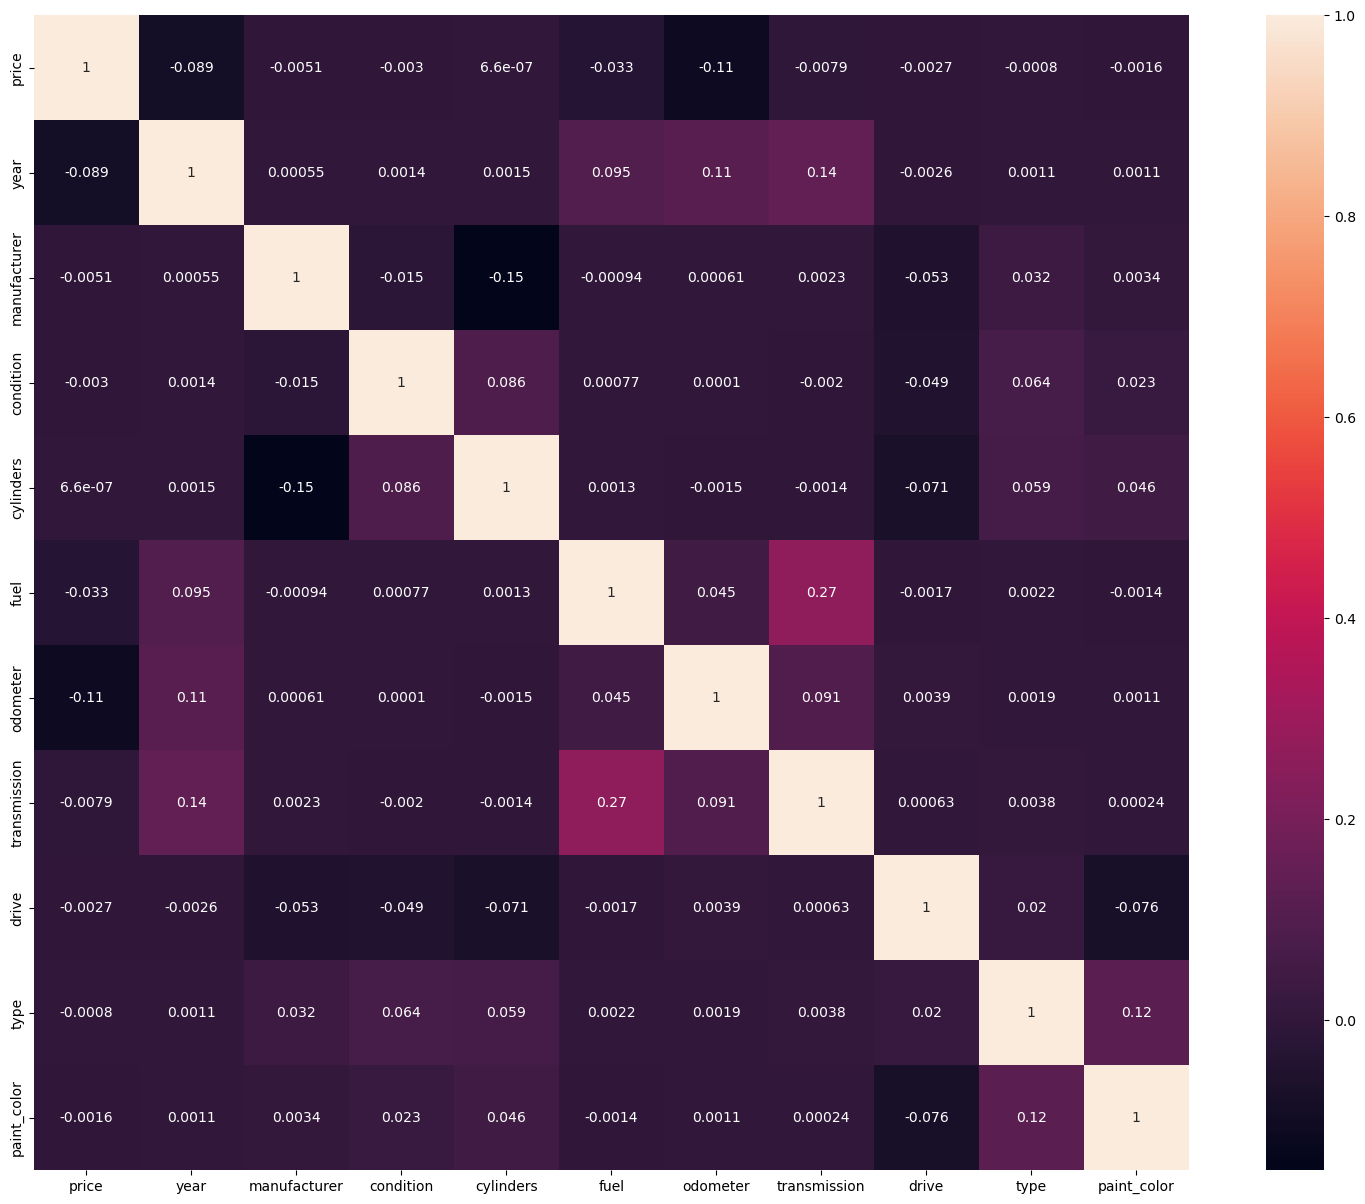

In [88]:
plt.subplots(figsize=(20, 15))
sns.heatmap(df_data.corr(), square = True, annot=True)
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [90]:
model_df = df_vehicle.drop(columns = ['manufacturer','title_status'])

In [91]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384639 entries, 27 to 413358
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         384639 non-null  Int64 
 1   year          384639 non-null  Int64 
 2   condition     384639 non-null  object
 3   cylinders     384639 non-null  object
 4   fuel          384639 non-null  string
 5   odometer      384639 non-null  Int64 
 6   transmission  384639 non-null  string
 7   drive         384639 non-null  object
 8   type          384639 non-null  object
 9   paint_color   384639 non-null  object
dtypes: Int64(3), object(5), string(2)
memory usage: 33.4+ MB


In [92]:
X1 = model_df.drop(columns = 'price')
y1 = model_df['price']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

To determine the best model complexity using one-hot encoding and cross-validation, I'll typically follow these steps:

- Prepare the Data: Ensure that the data is properly one-hot encoded.
- Define Models of Varying Complexity: Use Linear Regression models with different sets of features or regularization strengths.
- Evaluate Models: Use cross-validation to assess the performance of each model.
- Select the Best Model: Choose the model with the lowest mean squared error (MSE) on the training set.

In [94]:
def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None #placeholder for best model
    best_mse = np.inf #set best mse to infinity to begin
    for i in range(1, 6):
        poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(degree = i), make_column_selector(dtype_include=np.number)),
                                               (OneHotEncoder(drop = 'if_binary'), ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']))
        pipe = Pipeline([('transformer', poly_ordinal_ohe), ('linreg', LinearRegression())])
        pipe.fit(X_train, y_train)
        test_preds = pipe.predict(X_test)
        test_mse = mean_squared_error(y_test, test_preds)
        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [95]:
best_model = simple_cross_validation(X1_train, y1_train, X1_test, y1_test)
best_model.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(transformers=[('polynomialfeatures',
                                    PolynomialFeatures(degree=4),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000010C480C3EC0>),
                                   ('onehotencoder',
                                    OneHotEncoder(drop='if_binary'),
                                    ['condition', 'cylinders', 'fuel',
                                     'transmission', 'drive', 'type',
                                     'paint_color'])])),
  ('linreg', LinearRegression())],
 'verbose': False,
 'transformer': ColumnTransformer(transformers=[('polynomialfeatures',
                                  PolynomialFeatures(degree=4),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010C480C3EC0>),
                                 ('onehotencoder',
                      

To determine the best model complexity use polynomial features with a fixed degree (degree=4)

In [97]:
X11 = df_data.drop(columns = 'price')
y11 = df_data['price']
X11_train, X11_test, y11_train, y11_test = train_test_split(X11, y11, test_size=0.3, random_state=42)

In [98]:
def simple_cross_validation_le(X_train, y_train, X_test, y_test):
    best_pipe = None #placeholder for best model
    best_mse = np.inf #set best mse to infinity to begin
    for i in range(1, 6):
        pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)),
                         ('linreg', LinearRegression())])
        pipe.fit(X_train, y_train)
        test_preds = pipe.predict(X_test)
        test_mse = mean_squared_error(y_test, test_preds)
        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [99]:
lab_best_model = simple_cross_validation_le(X11_train, y11_train, X11_test, y11_test)
lab_best_model.get_params()

{'memory': None,
 'steps': [('pfeat', PolynomialFeatures(degree=3, include_bias=False)),
  ('linreg', LinearRegression())],
 'verbose': False,
 'pfeat': PolynomialFeatures(degree=3, include_bias=False),
 'linreg': LinearRegression(),
 'pfeat__degree': 3,
 'pfeat__include_bias': False,
 'pfeat__interaction_only': False,
 'pfeat__order': 'C',
 'linreg__copy_X': True,
 'linreg__fit_intercept': True,
 'linreg__n_jobs': None,
 'linreg__positive': False}

Use PolynomialFeatures using Label encoder (degree=3) for best model complexity

### Grid Search CV using One Hot Encoding

In [102]:
model_df1 = df_encoder.copy()

In [103]:
X2 = model_df1.drop(columns = 'price')
y2 = model_df1['price']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [104]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                          ('model', LinearRegression())])
param_dict = {'selector__n_features_to_select': [2, 4, 6, 8, 10]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X2_train, y2_train)
fs_train_preds = selector_grid.predict(X2_train)
fs_test_preds = selector_grid.predict(X2_test)
selector_train_mse = mean_squared_error(y2_train, fs_train_preds)
selector_test_mse = mean_squared_error(y2_test, fs_test_preds)
print(f'Grid Search Train MSE: {selector_train_mse}')
print(f'Grid SearchTest MSE: {selector_test_mse}')

Grid Search Train MSE: 131727044308812.56
Grid SearchTest MSE: 241652437526669.47


In [105]:
best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X2_train.columns[best_selector.get_support()]
coefs = best_model.coef_
print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=2)),
                ('model', LinearRegression())])
Features from best selector: Index(['condition_salvage', 'cylinders_12 cylinders'], dtype='object').
Coefficient values: 


,condition_salvage,cylinders_12 cylinders
model,-48608.537538,-44954.498326


### Grid Search CV using Label Encoder

In [107]:
selector_pipe_le = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                          ('model', LinearRegression())])

param_dict = {'selector__n_features_to_select': [2, 3, 4, 5, 6]}
selector_grid_le = GridSearchCV(selector_pipe_le, param_grid=param_dict)
selector_grid_le.fit(X11_train, y11_train)
fs_train_preds_le = selector_grid_le.predict(X11_train)
fs_test_preds_le = selector_grid_le.predict(X11_test)
selector_train_mse_le = mean_squared_error(y11_train, fs_train_preds_le)
selector_test_mse_le = mean_squared_error(y11_test, fs_test_preds_le)
print(f'Grid Search Train MSE: {selector_train_mse_le}')
print(f'Grid SearchTest MSE: {selector_test_mse_le}')

Grid Search Train MSE: 20581242.17807106
Grid SearchTest MSE: 20562004.788188543


In [108]:
best_estimator_le = selector_grid_le.best_estimator_
best_selector_le = best_estimator_le.named_steps['selector']
best_model_le = selector_grid_le.best_estimator_.named_steps['model']
feature_names_le = X11_train.columns[best_selector_le.get_support()]
coefs = best_model_le.coef_
print(best_estimator_le)
print(f'Features from best selector: {feature_names_le}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names_le, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=4)),
                ('model', LinearRegression())])
Features from best selector: Index(['year', 'fuel', 'odometer', 'transmission'], dtype='object').
Coefficient values: 


,year,fuel,odometer,transmission
model,-38.191732,-149.899881,-0.016102,130.725721


In [109]:
lr = LinearRegression().fit(X11_train, y11_train)
from sklearn.inspection import permutation_importance
r = permutation_importance(lr, X11_test, y11_test, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X11_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

odometer0.021 +/- 0.001
year    0.013 +/- 0.001
fuel    0.001 +/- 0.000
transmission0.001 +/- 0.000
manufacturer0.000 +/- 0.000


### Ridge Regression with GridSearch CV

In [111]:
poly_ordinal_ohe_4 = make_column_transformer((PolynomialFeatures(degree = 4), make_column_selector(dtype_include=np.number)),
                                            (OneHotEncoder(drop = 'if_binary'), ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']))
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('transformer', poly_ordinal_ohe_4), 
                       ('scaler', StandardScaler()), 
                       ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X1_train, y1_train)
ridge_train_preds = ridge_grid.predict(X1_train)
ridge_test_preds = ridge_grid.predict(X1_test)
ridge_train_mse = mean_squared_error(y1_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y1_test, ridge_test_preds)
print(f'Model Ridge Train MSE: {ridge_train_mse}')
print(f'Model Ridge Test MSE: {ridge_test_mse}')

Model Ridge Train MSE: 131727045308680.86
Model Ridge Test MSE: 241652444263447.28


In [112]:
ridge_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010C502E3BC0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'cylinders',
                                                   'fuel', 'transmission',
                                                   'drive', 'type',
                                                   'paint_color'])])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

In [113]:
ridge_grid.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010C4AAD1F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'cylinders',
                                                   'fuel', 'transmission',
                                                   'drive', 'type',
                                                   'paint_color'])])),
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=10000000000.0))])

### GridSearchCV best alpha for Ridge

In [115]:
ridge_pipe_2 = Pipeline([('transformer', poly_ordinal_ohe_4), 
                       ('scaler', StandardScaler()), 
                       ('ridge', Ridge(alpha=10000000000))])
ridge_pipe_2.fit(X1_train, y1_train)
ridge_train_preds_2 = ridge_pipe_2.predict(X1_train)
ridge_test_preds_2 = ridge_pipe_2.predict(X1_test)
ridge_train_mse_2 = mean_squared_error(y1_train, ridge_train_preds_2)
ridge_test_mse_2 = mean_squared_error(y1_test, ridge_test_preds_2)
print(f'Model Ridge alpha=10000000000.0 Train MSE: {ridge_train_mse_2}')
print(f'Model Ridge alpha=10000000000.0 Test MSE: {ridge_test_mse_2}')

Model Ridge alpha=10000000000.0 Train MSE: 131727045308680.86
Model Ridge alpha=10000000000.0 Test MSE: 241652444263447.28


In [116]:
poly_ordinal_ohe_4 = make_column_transformer((PolynomialFeatures(degree = 4), make_column_selector(dtype_include=np.number)),
                                            (OneHotEncoder(drop = 'if_binary'), ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']))
lr_pipe = Pipeline([('transformer', poly_ordinal_ohe_4),
                    ('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipe.fit(X1_train, y1_train)
lr_train_preds = lr_pipe.predict(X1_train)
lr_test_preds = lr_pipe.predict(X1_test)
lr_train_mse = mean_squared_error(y1_train, lr_train_preds)
lr_test_mse = mean_squared_error(y1_test, lr_test_preds)
print(f'Model Linearn Regression Train MSE: {lr_train_mse}')
print(f'Model Linearn Regression Test MSE: {lr_test_mse}')

Model Linearn Regression Train MSE: 131707097583327.7
Model Linearn Regression Test MSE: 241658415234024.06


Ridge Regression with GridSearch CV

In [118]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe_le = Pipeline([('scaler', StandardScaler()), 
                       ('ridge', Ridge())])
ridge_grid_le = GridSearchCV(ridge_pipe_le, param_grid = ridge_param_dict)
ridge_grid_le.fit(X11_train, y11_train)
ridge_train_preds_le = ridge_grid_le.predict(X11_train)
ridge_test_preds_le = ridge_grid_le.predict(X11_test)
ridge_train_mse_le = mean_squared_error(y11_train, ridge_train_preds_le)
ridge_test_mse_le = mean_squared_error(y11_test, ridge_test_preds_le)
print(f'Model Ridge with Label Encoder Train MSE: {ridge_train_mse_le}')
print(f'Model Ridge with Label Encoder Test MSE: {ridge_test_mse_le}')

Model Ridge with Label Encoder Train MSE: 20580599.466024145
Model Ridge with Label Encoder Test MSE: 20560532.119337235


In [119]:
ridge_pipe_le

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [120]:
ridge_grid_le.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=449.8432668969444))])

### Using Ridge(alpha=449.84) with Label encoder

In [122]:
ridge_pipe_le_2 = Pipeline([('pfeat', PolynomialFeatures(degree = 3, include_bias=False)), 
                       ('scaler', StandardScaler()), 
                       ('ridge', Ridge(alpha=449.84))])
ridge_pipe_le_2.fit(X11_train, y11_train)
ridge_train_preds_le_2 = ridge_pipe_le_2.predict(X11_train)
ridge_test_preds_le_2 = ridge_pipe_le_2.predict(X11_test)
ridge_train_mse_le_2 = mean_squared_error(y11_train, ridge_train_preds_le_2)
ridge_test_mse_le_2 = mean_squared_error(y11_test, ridge_test_preds_le_2)
print(f'Model Ridge with Label Encoder alpha=449.84 Train MSE: {ridge_train_mse_le_2}')
print(f'Model Ridge with Label Encoder alpha=449.84 Test MSE: {ridge_test_mse_le_2}')

Model Ridge with Label Encoder alpha=449.84 Train MSE: 19849958.62361429
Model Ridge with Label Encoder alpha=449.84 Test MSE: 19842900.97269426


### Using RandomForestRegressor to calculate MSE

In [124]:
rfr_pipe = Pipeline([('transformer', poly_ordinal_ohe_4), 
                   ('scaler', StandardScaler()),
                   ('model', RandomForestRegressor(n_estimators = 100))])
rfr_pipe.fit(X1_train, y1_train)
rfr_train_preds = rfr_pipe.predict(X1_train)
rfr_test_preds = rfr_pipe.predict(X1_test)
rfr_train_mse = mean_squared_error(y1_train, rfr_train_preds)
rfr_test_mse = mean_squared_error(y1_test, rfr_test_preds)
print(f'Model Random Forest Regressor Train MSE: {rfr_train_mse}')
print(f'Model Random Forest Regressor Test MSE: {rfr_test_mse}')

Model Random Forest Regressor Train MSE: 23238384858604.348
Model Random Forest Regressor Test MSE: 323466514021462.5


### Using RandomForestRegressor with Label encoder

In [126]:
rfr_pipe_le = Pipeline([('pfeat', PolynomialFeatures(degree = 3, include_bias=False)), 
                   ('scaler', StandardScaler()),
                   ('model', RandomForestRegressor(n_estimators = 100, max_depth=2))])
rfr_pipe_le.fit(X11_train, y11_train)
rfr_train_preds_le = rfr_pipe_le.predict(X11_train)
rfr_test_preds_le = rfr_pipe_le.predict(X11_test)
rfr_train_mse_le = mean_squared_error(y11_train, rfr_train_preds_le)
rfr_test_mse_le = mean_squared_error(y11_test, rfr_test_preds_le)
print(f'Model Random Forest Regressor with Label encoder Train MSE: {rfr_train_mse_le}')
print(f'Model Random Forest Regressor with Label encoder Test MSE: {rfr_test_mse_le}')

Model Random Forest Regressor with Label encoder Train MSE: 19684233.27358902
Model Random Forest Regressor with Label encoder Test MSE: 19684224.98992418


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In the Evaluation phase of the CRISP-DM process, multiple models were tested to predict the price of used cars. The focus was on identifying the model that provides the best balance between training accuracy and generalization to new data, using Mean Squared Error (MSE) as the primary evaluation metric.`model.

#### Models Tested:

1. **Linear Regression with Polynomial Features (One-Hot Encoding):**
   - The model was trained using polynomial features of degrees ranging from 1 to 5, along with one-hot encoding for categorical variables. The best model had a degree of 4.
   - Train MSE: 131727044308812.56
   - Test MSE: 241652437526669.47

2. **Ridge Regression with One-Hot Encoding:**
   - Ridge regression was implemented with polynomial features (degree 4) and one-hot encoding. A grid search was performed to find the best alpha value for regularization.
   - Best Alpha: 10000000000
   - Train MSE: 131727045308680.86
   - Test MSE: 241652444263447.28

3. **Random Forest Regressor with One-Hot Encoding:**
   - A Random Forest Regressor was trained with one-hot encoding and polynomial features (degree 4).
   - Train MSE: 23238384858604.348
   - Test MSE: 323466514021462.5

4. **Ridge Regression with Label Encoding:**
   - Ridge regression was also tested with label encoding. The best model used polynomial features (degree 3) and an alpha of 449.84.
   - Train MSE: 19849958.62361429
   - Test MSE: 19842900.97269426

In [133]:
simple_lr = LinearRegression().fit(X11_train, y11_train)
lr_coef_df = pd.DataFrame((simple_lr.coef_),columns =['coef'])
features_coef = ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 
                 'transmission', 'drive', 'type', 'paint_color']
lr_coef_df['features'] = pd.DataFrame(features_coef)

In [214]:
lr_coef_df

,coef,features
0,-38.192321,year
1,-1.674441,manufacturer
2,-11.676219,condition
3,1.053747,cylinders
4,-149.995733,fuel
5,-0.016099,odometer
6,130.826605,transmission
7,-16.472072,drive
8,0.432990,type
9,-2.081607,paint_color


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'year'),
  Text(1, 0, 'manufacturer'),
  Text(2, 0, 'condition'),
  Text(3, 0, 'cylinders'),
  Text(4, 0, 'fuel'),
  Text(5, 0, 'odometer'),
  Text(6, 0, 'transmission'),
  Text(7, 0, 'drive'),
  Text(8, 0, 'type'),
  Text(9, 0, 'paint_color')])

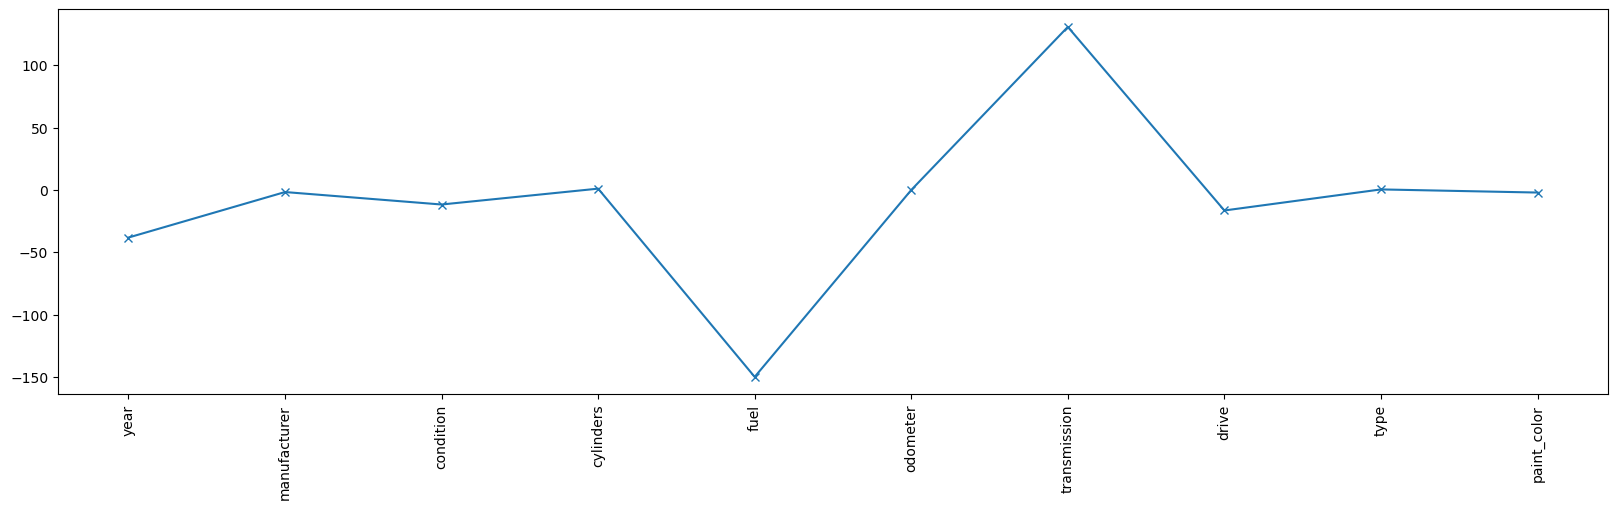

In [216]:
plt.fig = plt.figure(figsize=(20,5))
plt.plot(lr_coef_df['features'], lr_coef_df['coef'],marker = 'x')
plt.xticks(rotation=90)

#### Best Model:
- **Ridge Regression with Label Encoding** had the lowest Test MSE of 19842900.97, indicating it performed the best on unseen data.
- **Important Features:** The features that most significantly influenced the car prices included:
  - **Year:** Newer cars tend to have higher prices.
  - **Fuel Type:** The type of fuel (e.g., gas, diesel) impacts pricing.
  - **Odometer:** Higher mileage generally leads to a lower price.
  - **Transmission:** Automatic vs. manual transmission can affect the car's value.
  - **Manufacturer:** The brand of the car plays a significant role in determining its price.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

 
Our goal was to identify the key factors influencing the prices of used cars and provide actionable insights to help fine-tune your dealership's inventory strategy. By analyzing the given dataset and applying the optimal linear regression model, we have identified the primary factors driving the price of used cars.

**Key Findings**

1. **Car Title Status**  
   - A clean title status is essential for maintaining a higher resale value. Any deviations from a clean title (e.g., salvage, rebuilt) significantly reduce the car's price.

2. **Year of Manufacture**  
   - The age of the vehicle is a crucial factor. For each year increase in the vehicle's age, the price decreases by approximately **$38.19**. This depreciation reflects the market's preference for newer models.

3. **Manufacturer**  
   - The manufacturer significantly impacts the car's price. The regression model indicates that the price decreases by about **$1.67** for each unit increase in the manufacturer index, which is determined by a categorical encoding method. This suggests that some manufacturers may have a higher perceived value than others.

4. **Vehicle Condition**  
   - The condition of the vehicle is directly proportional to its price. Each unit increase in the condition index results in a decrease in price of about **$11.68**. Maintaining vehicles in top condition is crucial for maximizing their resale value.

5. **Engine Cylinders**  
   - The number of cylinders in the engine also influences the price. The price increases by approximately **$1.05** for each additional cylinder, indicating that vehicles with more powerful engines tend to be priced higher.

6. **Fuel Type**  
   - The majority of the dataset consisted of vehicles with gas engines, which naturally impacts the price. While other fuel types (e.g., diesel, electric) are less represented, their influence on pricing could be explored further in a more diverse dataset.

7. **Odometer Reading**  
   - The odometer reading is a critical determinant of the car's value. For every mile increase in the odometer reading, the price decreases by about **$0.02**. This highlights the importance of low-mileage vehicles in the used car market.

8. **Transmission Type**  
   - Most of the data comprised vehicles with automatic transmissions, which is a popular choice among consumers and influences the price positively.

9. **Drive Type**  
   - The drive type also affects the car's price, with rear-wheel drive (RWD) vehicles experiencing a decrease in price of around **$16.47**. This could be due to a preference for other drive types, such as all-wheel drive (AWD) or front-wheel drive (FWD), depntory management and increased sales.

**Conclusion**  
These findings provide a clear understanding of the factors that most significantly influence used car prices. By focusing on vehicles with clean titles, newer models, and well-maintained conditions, your dealership can optimize its inventory for higher profitability. Additionally, considering customer preferences for specific manufacturers, fuel types, and transmission modes can further fine-tune your sales strategy.

These insights should guide your purchasing decisions, marketing strategies, and pricing models, ultimately leading to better inventory management and increased sales.